In [8]:
from qmvpa import utils, factor, rsa
from data_loader_local import load_data
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from dep.utils import subset_units
from config import get_log_info
from itertools import product

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 5 seconds


In [9]:
# get roots 
log_root = '/tigress/qlu/logs/keras-resnet/log'
plt_root = '/tigress/qlu/logs/keras-resnet/plots'
pltdata_root = '/tigress/qlu/logs/keras-resnet/plots_data'

# define data name, model name 
data_name = 'cifar100'
model_name = 'resnet18'

# load data 
_, _, _, _, _, labels, data_info = load_data(data_name)
[n_classes, img_rows, img_cols, img_channels] = data_info
n_test_egs = len(labels)

# define params 
log_info_list = get_log_info(data_name, model_name)
n_subjs, layer_selected, n_layers, log_epochs, n_log_epochs = log_info_list
print('log epochs', log_epochs)
print('layer selected', layer_selected)

log epochs [  0   1   2   3   5   8  13  22  36  60 100]
layer selected [2, 10, 17, 25, 32, 40, 47, 55, 62]


In [10]:
# collect precomputed RDMs
wRSM_n_l2d = utils.list_2d(n_layers, n_log_epochs)
iRSM_n_l2d = utils.list_2d(n_layers, n_log_epochs)
wRSM_s_l2d = utils.list_2d(n_layers, n_log_epochs)
iRSM_s_l2d = utils.list_2d(n_layers, n_log_epochs)

# for each layer, look at the development 
for (i_l, i_e) in product(range(n_layers), range(n_log_epochs)):
    l, e = layer_selected[i_l], log_epochs[i_e]

    # plot dir and plot data dir 
    plt_dir = os.path.join(
        plt_root, data_name, model_name, 
        'epoch_%.3d' % e, 'rsa')    
    pltdata_dir = os.path.join(
        pltdata_root, data_name, model_name, 
        'epoch_%.3d' % e, 'rsa')
    # RSA and SRM result path
    rsa_result_fname = 'wirsa_ns_l%.2d.npy' % (l)
    rsa_result_path = os.path.join(pltdata_dir, rsa_result_fname)
    srm_result_fname = 'srm_l%.2d.npy' % (l)
    srm_result_path = os.path.join(pltdata_dir, srm_result_fname)
    # unpack information
    wRSM_n, iRSM_n, wRSM_s, iRSM_s = np.load(rsa_result_path)
    wRSM_n_l2d[i_l][i_e] = wRSM_n
    iRSM_n_l2d[i_l][i_e] = iRSM_n
    wRSM_s_l2d[i_l][i_e] = wRSM_s
    iRSM_s_l2d[i_l][i_e] = iRSM_s

In [11]:
"""
collect correlations: 
inter-subject RSM at time t vs. final within-subject RSM
"""
R_vals = np.zeros((n_layers, n_log_epochs))
P_vals = np.zeros((n_layers, n_log_epochs))

for (i_l, i_e) in product(range(n_layers), range(n_log_epochs)):
    l, e = layer_selected[i_l], log_epochs[i_e]
    R_vals[i_l, i_e], P_vals[i_l, i_e] = rsa.correlate_2RSMs(
        iRSM_s_l2d[i_l][i_e], wRSM_n_l2d[i_l][-1])


resnet18, cifar100



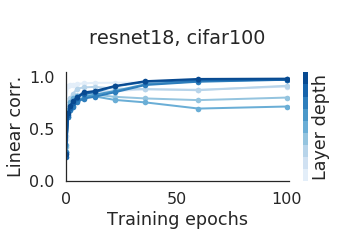

In [12]:
if model_name == 'conv':
    n_layers = 3
b_pals = sns.color_palette("Blues", n_colors = n_layers)
log_epochs_int = [int(log_epochs[i]) for i in range(len(log_epochs))]


f, ax = plt.subplots(1,1, figsize = (5, 2))

# plot a heatmap to get the color bar for neural network depth 
temp_plt = sns.heatmap(
    R_vals, cmap=sns.color_palette("Blues", n_colors = n_layers),
    cbar_kws={'label': 'Layer depth', 'ticks' : [0, n_layers]},
    ax = ax)
ax.cla()

for i_l in range(n_layers):
    ax.plot(log_epochs_int, R_vals[i_l,:], color = b_pals[i_l], marker = '.')

title_text = """
%s, %s
""" % (model_name, data_name)
# title_text = """
# 2nd order correlation
# inter-subject RSM vs. final within-subject RSM
# model: %s, data: %s
# """ % (model_name, data_name)
ax.set_title(title_text)
ax.set_xlabel('Training epochs')
ax.set_ylabel('Linear corr.')

ax.set_ylim([0, 1.05]);
ax.set_xlim([0, log_epochs_int[-1]+1]);
sns.despine()

print(title_text)

temp_path = '/tigress/qlu/logs/temp/'
fname = 'deve_%s_%s_s.png' % (model_name, data_name)
f.savefig(os.path.join(temp_path, fname),  bbox_inches='tight', dpi = 1000)

In [13]:
"""
collect correlations: 
inter-subject RSM at time t vs. within-subject RSM at time t
"""
R_vals = np.zeros((n_layers, n_log_epochs))
P_vals = np.zeros((n_layers, n_log_epochs))

for (i_l, i_e) in product(range(n_layers), range(n_log_epochs)):
    l, e = layer_selected[i_l], log_epochs[i_e]
    R_vals[i_l, i_e], P_vals[i_l, i_e] = rsa.correlate_2RSMs(
        iRSM_s_l2d[i_l][i_e], wRSM_n_l2d[i_l][i_e])

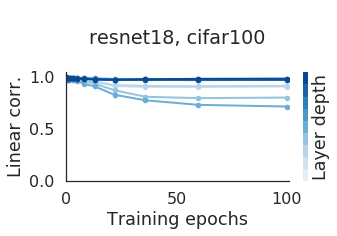

In [14]:
if model_name == 'conv':
    n_layers = 3
b_pals = sns.color_palette("Blues", n_colors = n_layers)
log_epochs_int = [int(log_epochs[i]) for i in range(len(log_epochs))]

f, ax = plt.subplots(1,1, figsize = (5, 2))
temp_plt = sns.heatmap(
    R_vals, cmap=sns.color_palette("Blues", n_colors = n_layers),
    cbar_kws={'label': 'Layer depth', 'ticks' : [0, n_layers]},
    ax = ax)
ax.cla()

for i_l in range(n_layers):
    ax.plot(log_epochs_int, R_vals[i_l,:], color = b_pals[i_l], marker = '.')

title_text = """
%s, %s
""" % (model_name, data_name)
ax.set_title(title_text)
ax.set_xlabel('Training epochs')
ax.set_ylabel('Linear corr.')

ax.set_ylim([0, 1.05]);
ax.set_xlim([0, log_epochs_int[-1]+1]);
sns.despine()